<a href="https://colab.research.google.com/github/ryankelley8/Predicting-Billboard-Hot-100-with-ARIMA-SARIMAX-WLS-and-LGBM-Machine-Learning-Final-Project-/blob/main/Better_Version_of_ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Clean Chart Dataset

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file
file_path = '/content/drive/MyDrive/ML/charts.csv'

# Read CSV and display
df_charts = pd.read_csv(file_path)

# Convert date to date/time
df_charts['date'] = pd.to_datetime(df_charts['date'])

# Sort By Songs
df_charts = df_charts.sort_values(by=['song','date'])

# Count missing values per column
missing_values = df_charts.isnull().sum()

# Display the results
print("Missing values per column originally:")
print(missing_values)

# Check average weeks on board of NaN
nan_last_week_df = df_charts[df_charts['last-week'].isnull()]
avg_weeks_on_board = nan_last_week_df['weeks-on-board'].mean()
print(f"Average weeks-on-board for NaN values in last-week originally: {avg_weeks_on_board}\n")

# Count how many have weeks-on-board > 1
count = df_charts[(df_charts['last-week'].isnull()) & (df_charts['weeks-on-board'] > 1)].shape[0]
print(f"Number of rows where last-week is NaN and weeks-on-board is greater than 1 originally: {count}\n")

# Replace NaN values in last-week with 100 where weeks-on-board = 1
df_charts.loc[(df_charts['weeks-on-board'] == 1) & (df_charts['last-week'].isnull()), 'last-week'] = 100

# Count missing values per column
missing_values = df_charts.isnull().sum()

# Display the results
print("Missing values per column after imputation:")
print(f"{missing_values}\n")

# Check average weeks on board of NaN
nan_last_week_df = df_charts[df_charts['last-week'].isnull()]
avg_weeks_on_board = nan_last_week_df['weeks-on-board'].mean()
print(f"Average weeks-on-board for NaN values in last-week after imputaion: {avg_weeks_on_board}\n")

# Deciding to remove NaN for now to remove noisy data
df_charts = df_charts.dropna(subset=['last-week']).copy()

# Count missing values per column
missing_values = df_charts.isnull().sum()

# Display the results
print("Missing values per column after removal:")
print(f"{missing_values}\n")

# Check average weeks on board of NaN
nan_last_week_df = df_charts[df_charts['last-week'].isnull()]
avg_weeks_on_board = nan_last_week_df['weeks-on-board'].mean()
print(f"Average weeks-on-board for NaN values in last-week after removal: {avg_weeks_on_board}\n")

# Count how many have weeks-on-board > 1
count = df_charts[(df_charts['last-week'].isnull()) & (df_charts['weeks-on-board'] > 1)].shape[0]
print(f"Number of rows where last-week is NaN and weeks-on-board is greater than 1 after removal: {count}\n")

# Unique Songs
unique_song_count = df_charts['song'].nunique()
print(f"Number of unique songs: {unique_song_count}\n")

# Count non-whole floats
count = df_charts[df_charts['last-week'] % 1 != 0]['last-week'].count()
print(f"Number of values with non-zero decimals in 'last-week': {count}\n")

# Remove values pre-2000 (data frame was too big)
df_charts = df_charts[df_charts['date'].dt.year >= 2000]

# Re Index
df_charts = df_charts.reset_index(drop=True)

# Check earliest and latest date
earliest_date = df_charts['date'].min()
latest_date = df_charts['date'].max()

print(f"Earliest date: {earliest_date}\n")
print(f"Latest date: {latest_date}\n")

# Convert last-week to int
df_charts['last-week'] = df_charts['last-week'].astype(int)

# Column types
print(df_charts.dtypes)

unique_song_count = df_charts['song'].nunique()
print(f"Number of unique songs: {unique_song_count}\n")

df_charts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values per column originally:
date                  0
rank                  0
song                  0
artist                0
last-week         32312
peak-rank             0
weeks-on-board        0
dtype: int64
Average weeks-on-board for NaN values in last-week originally: 1.4160373854914583

Number of rows where last-week is NaN and weeks-on-board is greater than 1 originally: 2628

Missing values per column after imputation:
date                 0
rank                 0
song                 0
artist               0
last-week         2628
peak-rank            0
weeks-on-board       0
dtype: int64

Average weeks-on-board for NaN values in last-week after imputaion: 6.115296803652968

Missing values per column after removal:
date              0
rank              0
song              0
artist            0
last-week         0
peak-rank         0
weeks-on-

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2001-10-20,75,#1,Nelly,100,75,1
1,2001-10-27,67,#1,Nelly,75,67,2
2,2001-11-03,61,#1,Nelly,67,61,3
3,2001-11-10,54,#1,Nelly,61,54,4
4,2001-11-17,40,#1,Nelly,54,40,5
...,...,...,...,...,...,...,...
112153,2001-01-13,63,www.memory,Alan Jackson,69,45,11
112154,2001-01-20,67,www.memory,Alan Jackson,63,45,12
112155,2001-01-27,77,www.memory,Alan Jackson,67,45,13
112156,2001-02-03,89,www.memory,Alan Jackson,77,45,14


# EDA

Correlation between last-week and rank: 0.8943267070971851

Correlation between peak-rank and rank: 0.8348886430797068

Correlation between weeks-on-board and rank: -0.38141254699492055



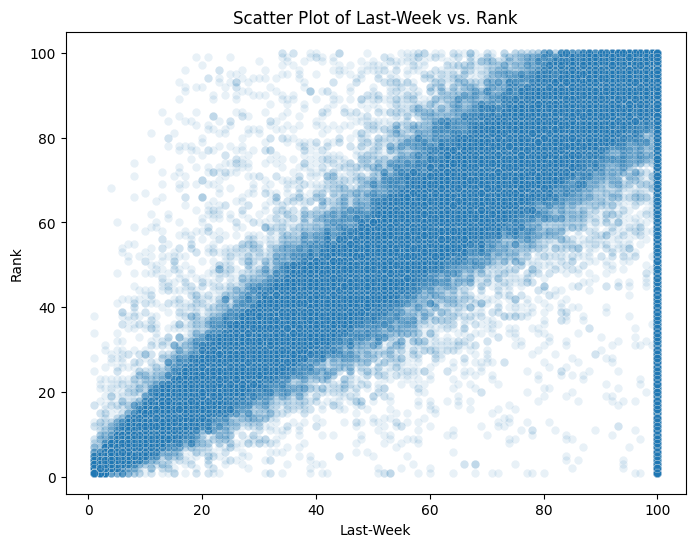

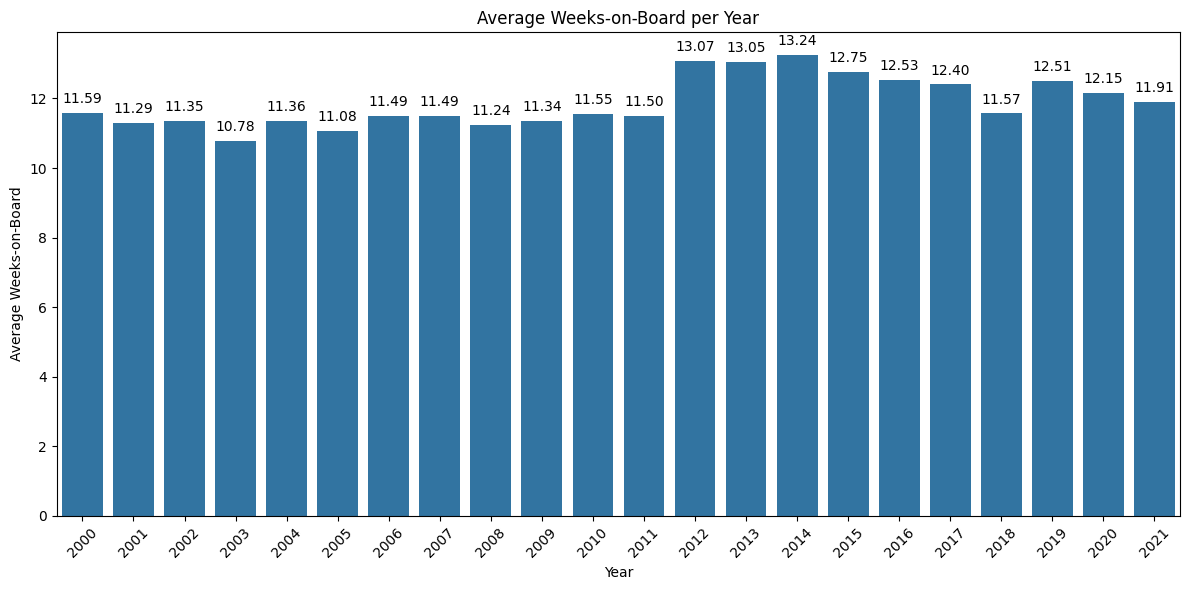

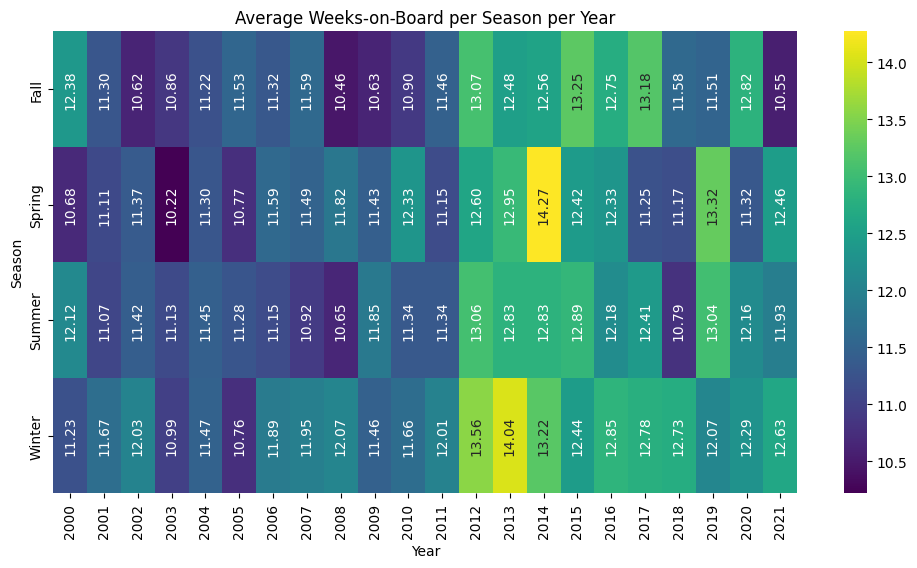

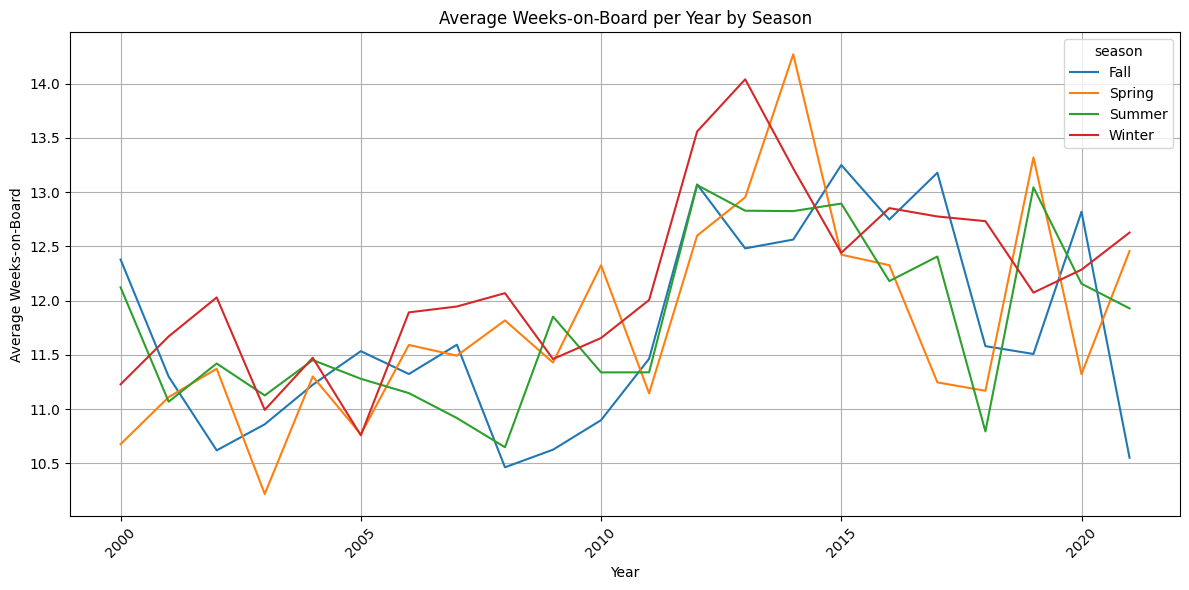

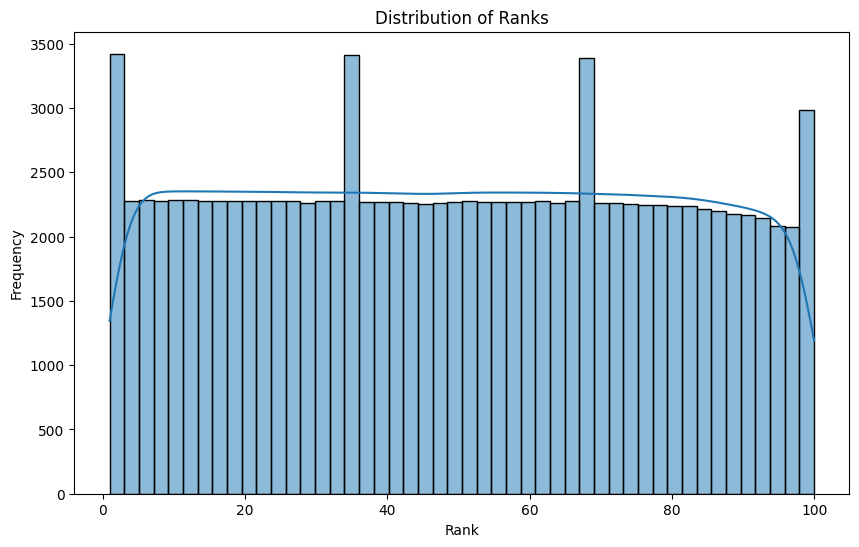

<Figure size 1000x600 with 0 Axes>

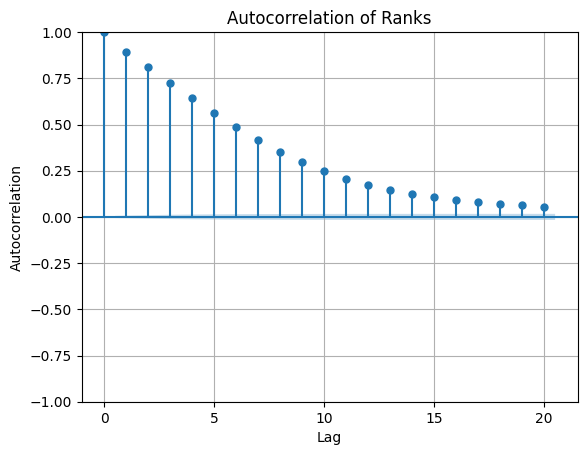

<Figure size 1000x600 with 0 Axes>

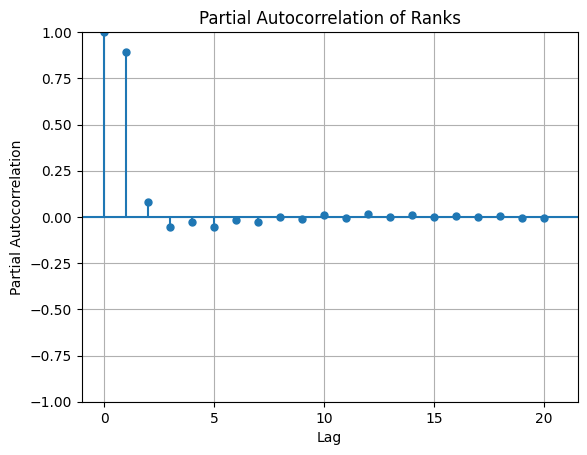

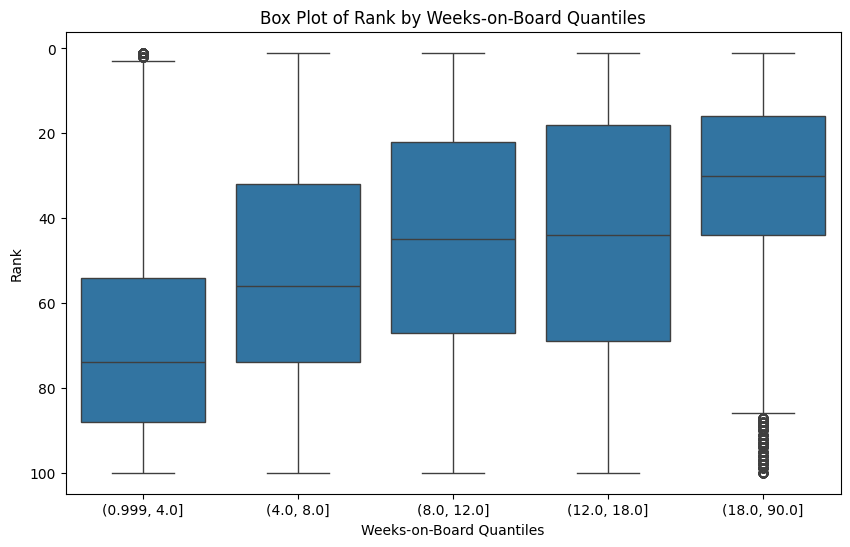

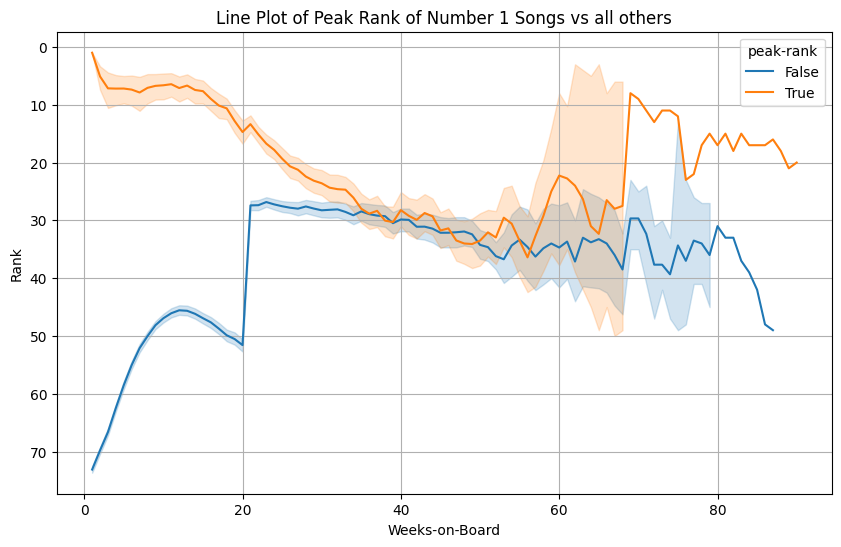

In [ ]:
# Calculate the correlation
correlation_lw = df_charts['last-week'].corr(df_charts['rank'])
correlation_pr = df_charts['peak-rank'].corr(df_charts['rank'])
correlation_wb = df_charts['weeks-on-board'].corr(df_charts['rank'])

# Print the correlation
print(f"Correlation between last-week and rank: {correlation_lw}\n")
print(f"Correlation between peak-rank and rank: {correlation_pr}\n")
print(f"Correlation between weeks-on-board and rank: {correlation_wb}\n")

# Scatter Plot of Last Week vs Rank
plt.figure(figsize=(8, 6))
sns.scatterplot(x='last-week', y='rank', data=df_charts, alpha=0.1)  # Use your DataFrame here
plt.title('Scatter Plot of Last-Week vs. Rank')
plt.xlabel('Last-Week')
plt.ylabel('Rank')
plt.show()

# Group data by year and calculate average weeks-on-board
avg_weeks_on_board_per_year = df_charts.groupby(df_charts['date'].dt.year)['weeks-on-board'].mean().reset_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
ax = sns.barplot(x='date', y='weeks-on-board', data=avg_weeks_on_board_per_year) # Defining ax here
plt.title('Average Weeks-on-Board per Year')
plt.xlabel('Year')
plt.ylabel('Average Weeks-on-Board')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Define a function to get the season based on the month
def get_season(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Fall'

# Group data by year and season and calculate average weeks-on-board
df_charts['season'] = df_charts['date'].dt.month.apply(get_season)
avg_weeks_on_board_per_season_year = df_charts.groupby([df_charts['date'].dt.year, 'season'])['weeks-on-board'].mean().reset_index()

# Create the heatmap using Seaborn
plt.figure(figsize=(12, 6))
heatmap_data = avg_weeks_on_board_per_season_year.pivot(index='season', columns='date', values='weeks-on-board')
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", annot_kws={'rotation': 90})
plt.title('Average Weeks-on-Board per Season per Year')
plt.xlabel('Year')
plt.ylabel('Season')
plt.show()

# Group data by year and season and calculate average weeks-on-board
avg_weeks_on_board_per_season_year = df_charts.groupby([df_charts['date'].dt.year, 'season'])['weeks-on-board'].mean().reset_index()

# Create the time series line chart using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='weeks-on-board', hue='season', data=avg_weeks_on_board_per_season_year)
plt.title('Average Weeks-on-Board per Year by Season')
plt.xlabel('Year')
plt.ylabel('Average Weeks-on-Board')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(True)
plt.show()

# drop season
df_charts = df_charts.drop(columns=['season'])

# Create a histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_charts['rank'], kde=True)
plt.title('Distribution of Ranks')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

# Create the autocorrelation plot
plt.figure(figsize=(10, 6))
plot_acf(df_charts['rank'], lags=20)
plt.title('Autocorrelation of Ranks')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Create the PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(df_charts['rank'], lags=20, method='ywm')
plt.title('Partial Autocorrelation of Ranks')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.qcut(df_charts['weeks-on-board'], 5), y='rank', data=df_charts)
plt.title('Box Plot of Rank by Weeks-on-Board Quantiles')
plt.xlabel('Weeks-on-Board Quantiles')
plt.ylabel('Rank')
plt.gca().invert_yaxis()
plt.show()

# Create the line plot for number 1 songs versus songs that peaked at 2-100
plt.figure(figsize=(10, 6))
sns.lineplot(x='weeks-on-board', y='rank', hue=(df_charts['peak-rank'] == 1), data=df_charts)
plt.title('Line Plot of Peak Rank of Number 1 Songs vs all others')
plt.xlabel('Weeks-on-Board')
plt.ylabel('Rank')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Feature Engineering

In [ ]:
# Season Column
# Define a function to get the season based on the month
def get_season(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Fall'

# Group data by year and season and calculate average weeks-on-board
df_charts['season'] = df_charts['date'].dt.month.apply(get_season)

# Lag Features (AR terms)
df_charts['rank_lag1'] = df_charts.groupby('song')['rank'].shift(1)
df_charts['rank_lag2'] = df_charts.groupby('song')['rank'].shift(2)
df_charts['rank_lag3'] = df_charts.groupby('song')['rank'].shift(3)

# Fill missing values forward, then backward if needed
max_rank = 100
debut_mask = df_charts['weeks-on-board'] == 1
df_charts.loc[debut_mask, ['rank_lag1']] = max_rank

df_charts['rank_lag1'] = df_charts.groupby('song')['rank_lag1'].ffill().fillna(max_rank)
df_charts['rank_lag2'] = df_charts.groupby('song')['rank_lag2'].ffill().fillna(max_rank)
df_charts['rank_lag3'] = df_charts.groupby('song')['rank_lag3'].ffill().fillna(max_rank)

# Momentum Features
df_charts['rank_change'] = df_charts['rank_lag2'] - df_charts['rank_lag1']  # Positive = improving
df_charts['rank_accel'] = df_charts['rank_lag1'] - 2*df_charts['rank_lag2'] + df_charts['rank_lag3']

###Create weeks_since_peak
peak_dates = df_charts[df_charts['rank'] == df_charts['peak-rank']].groupby(['song', 'artist'])['date'].min().reset_index()
peak_dates = peak_dates.rename(columns={'date': 'peak_date'})

# Merge this back with the original dataframe
df_charts = pd.merge(df_charts, peak_dates, on=['song', 'artist'], how='left')

# Calculate weeks since peak
df_charts['weeks_since_peak'] = (df_charts['date'] - df_charts['peak_date']).dt.days // 7

# For rows where current rank is the peak rank, weeks_since_peak should be 0
df_charts.loc[df_charts['rank'] == df_charts['peak-rank'], 'weeks_since_peak'] = 0

# Drop the temporary peak_date column
df_charts = df_charts.drop(columns=['peak_date'])

#df_charts['weeks_since_peak'] = df_charts['weeks-on-board'] - df_charts.groupby('song')['peak-rank'].transform('cummin').map(df_charts['weeks-on-board'])

# Peak Rank Impact (from your line plot)
df_charts['is_peak_hit'] = df_charts.groupby('song')['peak-rank'].transform(lambda x: int(x.min() == 1))

# Ad Fuller Test
#adf_result = adfuller(df_charts['rank'])
#print(f"ADF Statistic: {adf_result[0]}")
#print(f"p-value: {adf_result[1]:.20e}")
#print("Critical Values:")
#for key, value in adf_result[4].items():
    #print(f"   {key}: {value}")

# Fill missing values forward, then backward if needed
#df_charts['rank_lag1'] = df_charts['rank_lag1'].fillna(method='ffill').fillna(method='bfill')
#df_charts['rank_lag2'] = df_charts['rank_lag2'].fillna(method='ffill').fillna(method='bfill')
#df_charts['rank_change'] = df_charts['rank_change'].fillna(method='ffill').fillna(method='bfill')
#df_charts['rank_accel'] = df_charts['rank_accel'].fillna(method='ffill').fillna(method='bfill')

# Encode artist popularity
artist_stats = df_charts.groupby('artist').agg({
    'rank': ['mean', 'min', 'count'],
    'song': pd.Series.nunique
}).reset_index()

artist_stats.columns = ['artist', 'artist_avg_rank', 'artist_best_rank', 'artist_chart_appearances', 'artist_unique_songs']

df_charts = df_charts.merge(artist_stats, on='artist', how='left')

# Encode Song Populariry
song_stats = df_charts.groupby('song').agg({
    'rank': ['mean', 'min', 'count']
}).reset_index()

song_stats.columns = ['song', 'song_avg_rank', 'song_best_rank', 'song_weeks_on_chart']

df_charts = df_charts.merge(song_stats, on='song', how='left')

# Drop peak-rank and last-week
df_charts = df_charts.drop(columns=['last-week', 'artist'])

# drop song
df_charts = df_charts.drop(columns=['song'])
df_charts = df_charts.dropna()

# One Hot Encode season
df_charts = pd.get_dummies(df_charts, columns=['season'], drop_first=True)

# Column types
print(df_charts.dtypes)

# Calculate correlations with 'rank'
correlations = df_charts.corr()['rank'].drop('rank')  # Drop 'rank' itself

# Display the correlations
print(correlations)

#Count missing values
missing_values = df_charts.isnull().sum()
print(missing_values)

df_charts

date                        datetime64[ns]
rank                                 int64
peak-rank                            int64
weeks-on-board                       int64
rank_lag1                          float64
rank_lag2                          float64
rank_lag3                          float64
rank_change                        float64
rank_accel                         float64
weeks_since_peak                   float64
is_peak_hit                          int64
artist_avg_rank                    float64
artist_best_rank                     int64
artist_chart_appearances             int64
artist_unique_songs                  int64
song_avg_rank                      float64
song_best_rank                       int64
song_weeks_on_chart                  int64
season_Spring                         bool
season_Summer                         bool
season_Winter                         bool
dtype: object
date                       -0.007606
peak-rank                   0.835711
weeks-on-

,date,rank,peak-rank,weeks-on-board,rank_lag1,rank_lag2,rank_lag3,rank_change,rank_accel,weeks_since_peak,is_peak_hit,artist_avg_rank,artist_best_rank,artist_chart_appearances,artist_unique_songs,song_avg_rank,song_best_rank,song_weeks_on_chart,season_Spring,season_Summer,season_Winter
0,2001-10-20,75,75,1,100.0,100.0,100.0,0.0,0.0,0.0,0,36.231214,1,173,14,40.1,22,20,False,False,False
1,2001-10-27,67,67,2,75.0,100.0,100.0,25.0,-25.0,0.0,0,36.231214,1,173,14,40.1,22,20,False,False,False
2,2001-11-03,61,61,3,67.0,75.0,100.0,8.0,17.0,0.0,0,36.231214,1,173,14,40.1,22,20,False,False,False
3,2001-11-10,54,54,4,61.0,67.0,75.0,6.0,2.0,0.0,0,36.231214,1,173,14,40.1,22,20,False,False,False
4,2001-11-17,40,40,5,54.0,61.0,67.0,7.0,-1.0,0.0,0,36.231214,1,173,14,40.1,22,20,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112153,2001-01-13,63,45,11,69.0,49.0,45.0,-20.0,16.0,10.0,0,60.996667,28,300,19,63.4,45,15,False,False,True
112154,2001-01-20,67,45,12,63.0,69.0,49.0,6.0,-26.0,11.0,0,60.996667,28,300,19,63.4,45,15,False,False,True
112155,2001-01-27,77,45,13,67.0,63.0,69.0,-4.0,10.0,12.0,0,60.996667,28,300,19,63.4,45,15,False,False,True
112156,2001-02-03,89,45,14,77.0,67.0,63.0,-10.0,6.0,13.0,0,60.996667,28,300,19,63.4,45,15,False,False,True


# Find Best Model Order

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Stationarity test to get a good 'd'
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1]  # If < 0.05, it's stationary

# Choose d
p_value = test_stationarity(df_charts['rank'])
d_values = [0, 1, 2] if p_value > 0.05 else [0]  # try differencing if not stationary

# Grid search for (p, d, q)
import itertools

p = q = range(0, 4)  # You can increase to 5–6 if you want slower, more thorough search
pdq = list(itertools.product(p, d_values, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(df_charts['rank'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        print(f"ARIMA{order} - AIC:{results.aic}")
    except:
        continue

print(f"\n✅ Best ARIMA Order: {best_order} with AIC: {best_aic}")

ADF Statistic: -57.187189174432916
p-value: 0.0
ARIMA(0, 0, 0) - AIC:1070987.9838426933
ARIMA(0, 0, 1) - AIC:987359.5901270241
ARIMA(0, 0, 2) - AIC:945033.8209550238
ARIMA(0, 0, 3) - AIC:925772.6724765638
ARIMA(1, 0, 0) - AIC:893501.705253358
ARIMA(1, 0, 1) - AIC:892885.3493409173
ARIMA(1, 0, 2) - AIC:892434.027926764
ARIMA(1, 0, 3) - AIC:892383.5999965516
ARIMA(2, 0, 0) - AIC:892799.449752948
ARIMA(2, 0, 1) - AIC:892536.0816647754
ARIMA(2, 0, 2) - AIC:892077.5888178212
ARIMA(2, 0, 3) - AIC:892075.6987476681
ARIMA(3, 0, 0) - AIC:892440.7825414918
ARIMA(3, 0, 1) - AIC:892069.5987810635
ARIMA(3, 0, 2) - AIC:892539.9707995282
ARIMA(3, 0, 3) - AIC:891931.227949349

✅ Best ARIMA Order: (3, 0, 3) with AIC: 891931.227949349


# RUN ARIMA and Weighted Least Squares

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create df_charts_ARIMA
df_charts_ARIMA = df_charts.copy()
# Add log rank column
df_charts_ARIMA['log_rank'] = np.log(df_charts_ARIMA['rank'])
#df_charts_ARIMA = df_charts.drop(columns=['rank_lag2']).copy()

# Correlation > 0.3 Remove rank_lag1/2 and artsit_best_rank
exog_vars = [
    'weeks-on-board',
    'weeks_since_peak',
    'is_peak_hit',
    'artist_avg_rank',
    'song_avg_rank',
    'song_best_rank',
    'song_weeks_on_chart',
]

# Best Parameters
best_model = ARIMA(
    endog=df_charts_ARIMA['log_rank'],
    exog=df_charts_ARIMA[exog_vars],  # From EDA insights
    order=(3,0,3)
)
best_results = best_model.fit()
print(f"Best ARIMA Order Summary:\n{best_results.summary()}\n")

# SARIMAX Best Parameters
sarimax_model = SARIMAX(endog=df_charts_ARIMA['log_rank'], exog=df_charts_ARIMA[exog_vars], order=(3,0,3))
sarimax_results = sarimax_model.fit()

print(f"SARIMAX Best Order Summary:\n{sarimax_results.summary()}")

# Calculate Residuals
residuals_1 = best_results.resid

# Compute WLS weights
weights_1 = 1 / (residuals_1 ** 2 + 1e-8)  # small epsilon to avoid division by zero

# Compare to Weighted Least Squares Regression
X = sm.add_constant(df_charts_ARIMA[exog_vars])
y = df_charts_ARIMA['log_rank']
wls_model_1 = WLS(y, X, weights=weights_1)
wls_results_1 = wls_model_1.fit()
print(f"Wedighted Least Squares ARIMA Summary:\n{wls_results_1.summary()}")

# Calculate Residuals
residuals_2 = sarimax_results.resid

# Compute WLS weights
weights_2 = 1 / (residuals_2 ** 2 + 1e-8)  # small epsilon to avoid division by zero

# Compare to Weighted Least Squares Regression
X = sm.add_constant(df_charts_ARIMA[exog_vars])
y = df_charts_ARIMA['log_rank']
wls_model_2 = WLS(y, X, weights=weights_2)
wls_results_2 = wls_model_2.fit()
print(f"Wedighted Least Squares SARIMAX Summary:\n{wls_results_2.summary()}")

Best ARIMA Order Summary:
                               SARIMAX Results                                
Dep. Variable:               log_rank   No. Observations:               112158
Model:                 ARIMA(3, 0, 3)   Log Likelihood              -28366.700
Date:                Sun, 11 May 2025   AIC                          56763.400
Time:                        02:51:30   BIC                          56907.815
Sample:                             0   HQIC                         56807.002
                             - 112158                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.3706      0.010    247.818      0.000       2.352       2.389
weeks-on-board          0.0235      0.000    100.671      0.000       0.023   

# LGBM Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 5345, number of used features: 12
[LightGBM] [Info] Start training from score 51.622077
Fold 1 RMSE: 5.98
Fold 1 MAE: 3.40
Fold 1 R²: 0.953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 10671, number of used features: 12
[LightGBM] [Info] Start training from score 50.271765
Fold 2 RMSE: 4.88
Fold 2 MAE: 2.87
Fold 2 R²: 0.972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

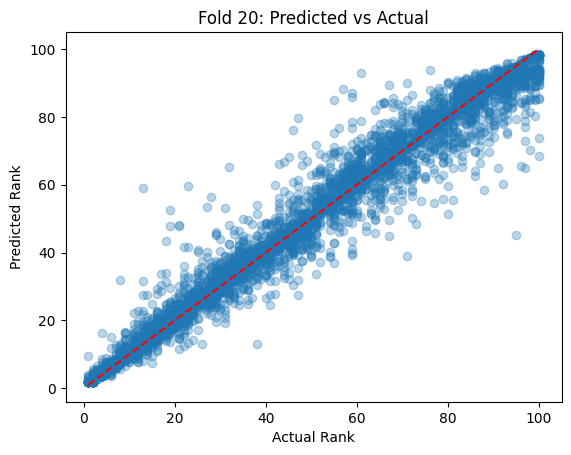

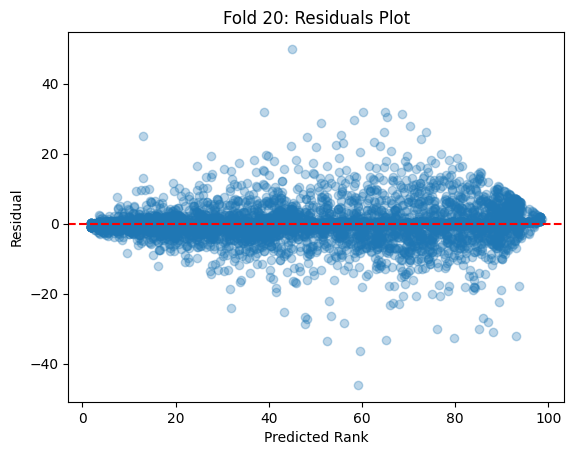

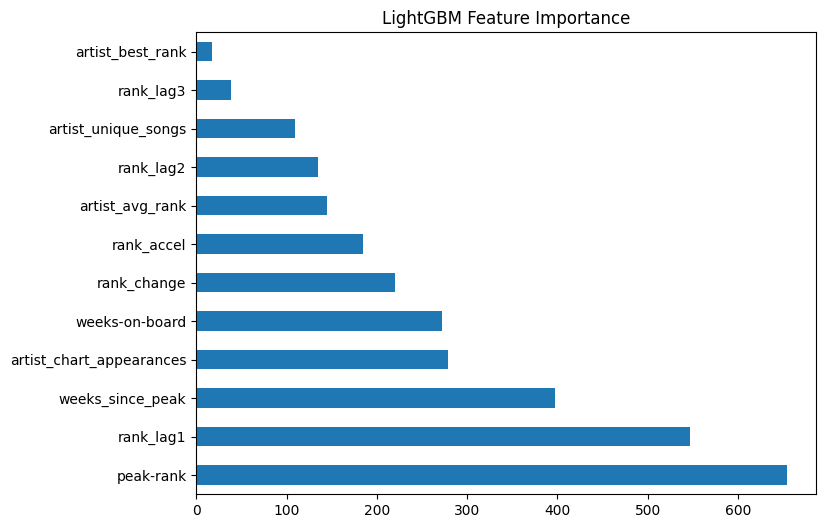

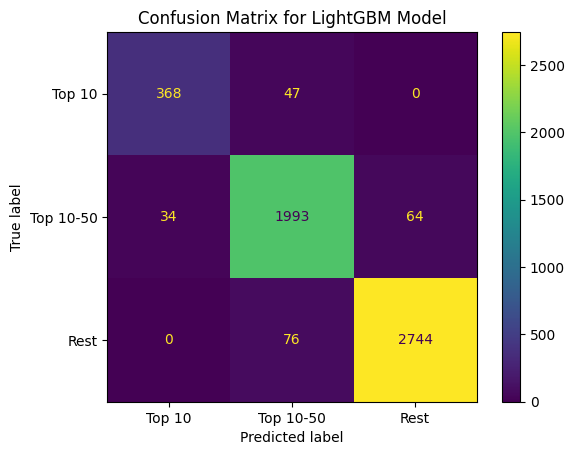

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import label_binarize


# sort df_charts by date
#df_charts = df_charts.sort_values(by='date')

exog_vars = [
    'rank',
    'rank_lag1',
    'rank_lag2',
    'rank_accel',
    'weeks-on-board',
    'weeks_since_peak',
    'is_peak_hit',
    'artist_avg_rank',
    'artist_best_rank',
    'song_avg_rank',
    'song_best_rank',
    'peak-rank'
]

# drop 'date'
df_charts_LMST = df_charts.drop(columns=['date','song_best_rank','song_weeks_on_chart','song_avg_rank','season_Winter','season_Summer','season_Spring','is_peak_hit']).copy()
#df_charts.drop(columns=['date']).copy()
#df_charts.drop(columns=['date','song_best_rank','rank_lag3','season_Winter','season_Summer','season_Spring','is_peak_hit','artist_best_rank']).copy()
#df_charts.drop(columns=['date']).copy()
#df_charts[exog_vars].copy()

# Split
X = df_charts_LMST.drop(columns=['rank'])
y = df_charts_LMST['rank']

# Train/test split for time-series
tscv = TimeSeriesSplit(n_splits=20)
model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Fold {fold+1} RMSE: {rmse:.2f}")
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_test, preds)
    print(f"Fold {fold+1} MAE: {mae:.2f}")
    r2 = r2_score(y_test, preds)
    print(f"Fold {fold+1} R²: {r2:.3f}")

# Actual Vs. Predicted
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title(f'Fold {fold+1}: Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Residual Plot
residuals = y_test - preds
plt.scatter(preds, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rank')
plt.ylabel('Residual')
plt.title(f'Fold {fold+1}: Residuals Plot')
plt.show()

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh', figsize=(8,6))
plt.title('LightGBM Feature Importance')
plt.show()

# Define thresholds to discretize predictions into classes (e.g., top 10, top 50, rest)
thresholds = [10, 50]

# Convert predictions and actual values to classes based on thresholds
y_test_classes = np.digitize(y_test, bins=thresholds)
y_pred_classes = np.digitize(preds, bins=thresholds)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Top 10', 'Top 10-50', 'Rest'])
disp.plot()
plt.title('Confusion Matrix for LightGBM Model')
plt.show()